In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

import os 
import sys 

# TODO: remove '..' if run from root folder
home = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
pths = [os.path.join(home, 'astrobot'), os.path.join(home, 'astrobot', 'tests')]

for pth in pths: 
    if pth not in sys.path: sys.path.insert(0, pth)

from astrobot import pmf

import numpy as np 
import pandas as pd
from pprint import pprint 
import matplotlib.pyplot as plt 
from functools import reduce 

def pp(x, *args): 
    pprint(x) if not args else (pprint(x), pp(*args))


In [7]:
from astrobot import bld_stock 

def search_comdf_var(var):
    return [col for col in _comdf.columns if var.lower() in col.lower()]

# TODO: convert to parquet 
_comdf = bld_stock.comstock_df()
comdf = bld_stock.processed_comstock_df(_comdf)
comdf.head(5)

,cz_cat,cz,btype_cat,btype,weight,metadata_index,bldg_id,eui
0,3A,3,SmallOffice,12,7.041741,0,105,96.760416
1,3A,3,SmallOffice,12,7.041741,1,170,112.887152
2,3A,3,RetailStripmall,9,1.947971,2,254,455.818507
3,3A,3,RetailStripmall,9,1.947971,3,313,322.748017
4,3A,3,SmallOffice,12,7.041741,4,318,196.152142


,ps,qs
bins,,
0,0.064516,56.480940
1,0.000000,67.184505


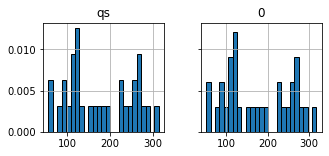

In [64]:
# Joint Pmf
btype = "LargeOffice"
cz = "5B"
data = comdf.query("btype_cat == '{}' & cz_cat == '{}'".format(btype, cz))

# Plot the empirical distribution of marginal EUI: sum_ij{ P(eui, btype_i, cz_j) }
eui = pmf.Pmf(data.eui, 25, data.weight, id=data.index)
_, ax = plt.subplots(1,2, figsize=(5, 2), sharey=True)
pmf.plt_hist(eui, edgecolor='black', ax=ax[0]); 
pd.DataFrame(data=eui.qs_arr).hist(
    density=True, bins=eui.bins, edgecolor='black', ax=ax[1])
eui.df.head(2) 

# dfj = pmf.JointPmf([1, 0, 0, 1], [1, 0, 0, 1], bins1=4, bins2=4)
# def marginalize()


In [5]:
print(_comdf.shape)
print(_comdf.weight.sum())

from tests.pmf_test import test_make_pmf, test_make_bin_idx, test_make_bin_edges
from tests.pmf_test import test_make_joint_pmf 

from scipy.stats._binned_statistic import binned_statistic
pd.set_option("display.precision", 6)

test_make_bin_edges()
test_make_bin_idx()
test_make_pmf()

test_make_joint_pmf()


(344057, 88)
1543251.4395087715


In [6]:
"""
- Goal: Show stairstep?
- Goal: Show forward/inverse prob. models?
- Eval: Show prediction accuracy by testing on validation set. 
"""
theta = "epd"
X = ["cz", "vintage", "btype"]
y = "eui"
evidence = {"eui":[25, 50, 75], "cz":"4B", "vintage":"pst80s", "btype":"LargeOffice"}

# Infer parameter epd from y, X

# Construct data according to Pyro
dag = DAG(data=compdf)  

# Model joint and marginal probability of p(X, eui)
for varx in X: 
    epd_eui_pmf = prob_joint(varx, "eui", dag=dag)
    m1, m2 = prob_marginal(varx, dag=dag), prob_marginal("eui", dag=dag)
    plt_hist3(epd_eui_pmf, m1, m2)
    
# Forward modeling (p(y=[25,50,75]|X,theta)) ??
for x in X: 
    eui_pmf = prob_cond(prior="eui", likelihood=5, marginal=5)

# Model inverse p(X=epd | eui=[25, 50, 75])
for eui_pctile in [25, 50, 75]:
    epd_pmf = prob_cond(prior"epd", likelihood=likelihood, marginal="eui", dag=dag)
    plt_hist(epd_pmf)
    info_metric = cond_entropy(epd_pmf)  # how much info obtained about epd given eui
    print(info_metric)



SyntaxError: invalid syntax (Temp/ipykernel_22204/3668422546.py, line 28)

In [ ]:
# TODO: 
# Xclean up function: _make_joint_pmf(data) 
# Xtest _make_joint_pmf(data)
# XJointPmf(dataset) -> df w/ multiindex
# write: margin_pmf(joint_pmf) -> Pmf
# test p(x, y) = p(x) & p(y) = p(x) p(x|y) = p(y) p(y|x)
# plot joint of eui and cz (same as query)
# write cond_pmf
# p(e,cz,v) = p(e|cz,v) p(cz|v) p(v) 


In [ ]:
from scipy.stats import binned_statistic 

# Flip two coins, probability of state = 2^2 = 4 states:
# Joint pmf is:
# [Hx_Hy, Hy_Tx]
# [Tx_Hy, Ty_Tx]
pxy = np.array(
  # y1: H, x2:T
    [[.25, .25],  # x1: H 
     [.25, .25]]) # x2: T
# p(x, y) = p(x) & p(y) = p(x) p(x|y) = p(y) p(y|x) 
# Marginalize ith x row by:
# 1. Summing joint through all j cols 
# 2. Normalize with factor p(x_ij) = 1 / sum_ij( p(x_ij, y_ij))    
# p(x_i=1) = sum_j p(x_i=1, y_j) 
#px = 1 / np.sum([xy_ij for x_i in pxy for xy_ij in x_i])
px_i = np.array([[np.sum(x_i)] for x_i in pxy])
# pp(px_i)
# For py iterate through column space
py_i = np.array([[np.sum(y_j)] for y_j in pxy.T]).T
# pp(py_i)
